# Изучение архитектуры на основе U-Net в PyTorch
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1BKkyFDzl-qOLvYTV_DD3LTt-mfy9FxWt#scrollTo=9ic0H8b8qO5z) -->

В предыдущих практиках по работе с `PyTorch` мы рассмотрели задачу классификации. Однако, это не едиственная задача, которую можно решать нейронными сетями. В данном примере рассмотрим задачу семантической сегментации.  

В задачах семантической сегметнации требуется выделение каких-либо объектов в выходных данных (например, изображении) из входных данных (например, входного изображения). Как правило, такие задачи решаются формированием карт признаков конечного размера (например, совпадающего с размером исходного изображения) и имеющих число каналов, соотвествующее числу классов. Затем по всем картам признаков проводится попиксельная классификация.

## Импорт torch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [3]:
import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

In [4]:
сolab_requirements = ["pip install -q albumentations",
                      "pip install -q torchinfo",
                      "pip install -q segmentation_models_pytorch"]
import sys, subprocess

def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in сolab_requirements:
        run_subprocess_command(i)

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

import albumentations
from albumentations.pytorch import ToTensorV2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader

In [6]:
import segmentation_models_pytorch as smp

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [7]:
import urllib
if not os.path.exists('torch_trainer.py' ):
    url = "https://github.com/MVRonkin//Computer-Vision-Course_lec-practice/raw/refs/heads/main/2025//WS/torch_trainer.py"
    filename, headers = urllib.request.urlretrieve(url,filename='torch_trainer.py' )

In [8]:
from torch_trainer import *

In [9]:
device = setup_experiment()

[✓] Device: cuda | Seed: 42 | TF32: True


# Набор данных для сегментации

## загрузка данных

Перед тем как описать архитектуру загрузим набор данных. В этом примере мы будем использовать набор данных [`The Oxford-IIIT Pet Dataset`](https://www.robots.ox.ac.uk/~vgg/data/pets/), который может быть найден на [по официальной ссылке](https://www.robots.ox.ac.uk/~vgg/data/pets/). Набор данных содержит изображения кошек и собак, которые требуется сегментировать и аннотацию к каждому изорбажению.

Аннотация в данном случае подразумевает маску, по которой должен быть сегментирован объект на изображении. Все аннотации имеют размер, соответствующий изображению. Каждая маска может принимать одно из трех значений:
* 1 - пиксель пренадлежит классу петомец;
* 2 - пиксель пренадлежит классу фон;
* 3 - пиксель пренадлежит классу граница.
Однако, в данном примере мы будем рассматривать только 1 и 2-й классы.

Отметим, что задача распознования границ объектов представляет отдельный класс задач семантической сегментации, подразумевающий специфичный вид функции потерь.

Попробуем загрузить набор данных. В данном случа набор будет представлен двумя архивами, один с изображениями, и второй с их анннотацией. Отметим, что данный урок вдохнавлен [этим примером](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/).

Также отметим, что на самом деле набор данных входит в модуль `torchvision.datasetes`. Для вызова из набора можно воспользоваться следующим кодом.
```
trainvaldata = torchvision.datasets.OxfordIIITPet(root  = './data',
                                                  split = 'trainval',
                                                  target_types = 'segmentation',
                                                  download  = True,
                                                  transform = train_transforms)


testdata = torchvision.datasets.OxfordIIITPet(root = './data',
                                             split = 'test',
                                             target_types = 'segmentation',
                                             download  = True,
                                             transform = test_transforms)
```                                             

In [10]:
import os
from torchvision.datasets.utils import download_and_extract_archive

In [11]:
url_images = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
root_directory = os.path.join(os.getcwd(),'data','pets')

archive_name = url_images.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)

download_and_extract_archive(url_images, root_directory)


url_anno   = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

archive_name = url_anno.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)

download_and_extract_archive(url_anno, root_directory)

Посмотрим содержания созданного архива. Архив содержит директорию изображениями `images` и директорию с аннотацией `images/trimaps`. Всего в архиве должно быть 7393 изображения.

In [12]:
content = os.listdir(root_directory)
print(content)
print('n images = ',len(os.listdir(os.path.join(root_directory, 'images'))))
# print('n anno = ',len(os.listdir(os.path.join(dataset_directory, content[0], "trimaps" ))))

['annotations', 'annotations.tar.gz', 'images', 'images.tar.gz']
n images =  7393


Теперь пробуем разбить изображения на тренировочную, валидационную и тестовую выборки.

В тренировочную выборку поместим 6000 случайно выбранных изображений.
В тестовую выборку поместим 100 случайно выбранных изображений.

In [13]:
N_TRAIN = 6000
N_TEST  = 100
STEP    = 5

images_directory = os.path.join(root_directory, "images")
masks_directory  = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = os.listdir(images_directory)

images_filenames = [i for i in images_filenames
                        if os.path.splitext(i)[-1]
                            in ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')]

os.path.splitext('/path/to/somefile.ext')

random.shuffle(images_filenames)

train_images_filenames = images_filenames[:N_TRAIN:STEP]
val_images_filenames   = images_filenames[N_TRAIN:-N_TEST:STEP]
test_images_filenames  = images_filenames[-N_TEST::STEP]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

1200 258 20


### Проверка полного изображеия и его маски

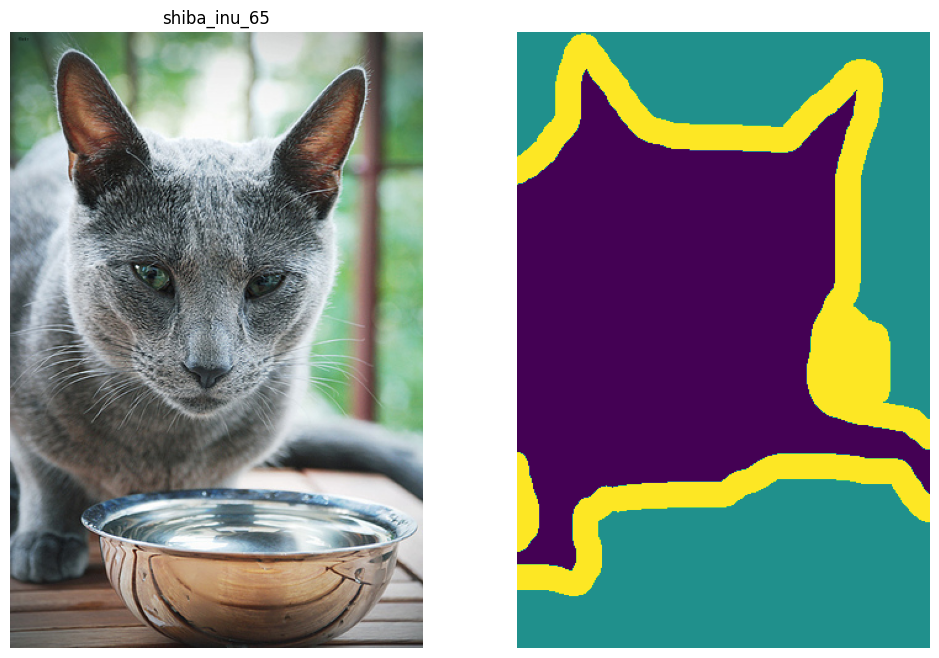

In [14]:
fig,axs = plt.subplots(1,2,figsize=(12,8))
img = Image.open(os.path.join(images_directory,test_images_filenames[0]))
anno = Image.open(os.path.join(masks_directory,test_images_filenames[0]).replace(".jpg", ".png"))
axs[0].imshow(img); axs[0].set_axis_off(); axs[0].set_title(images_filenames[0].split('.')[0])
axs[1].imshow(anno); axs[1].set_axis_off();

Обратите внимание, что 
* маска в формате png
* название файла маски и изображения одинаковые
* название - порода и номер фото для породы
* маска вкелючает как внутреннюю маску, так и контур как разные цвета.

## класс датасет

Для загрузки наборов данных создаим свой загрузчик. Данная тема уже поднималась в рамках урока по основам работы с данными в `PyTorch`. Напомним, что  свой набор данных при помощи  класса наследника `Dataset`.
Загрузчик данных должен иметь следующий вид.
```python
class CustomImageDataset(Dataset):
    def __init__(self,...):
        ...

    def __len__(self):
       ...

    def __getitem__(self, idx):
        ...
        return sample
```      
Подробную информацию можно найти в документации [тут](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets) и в официальном примере [тут](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

В нашем случае мы создадим загрузчик данных `PetsDataset`. Загрузчик буде позволять работать с заданным списком изображений, указанным в `images_filenames`. Изображения будут браться из директории `images_directory`, а маски из директории `masks_directory`. Для изображений будут доступны преобразования `transforms`. В рамках класса загрузчика функция `__getitem__` является основной. Она должна получать на входе номер элмента и выдавать для номера входные и выходные данные. Также класс будет содержать функцию `preprocess_mask`, цель которой в том, чтобы убрать ненужный класс рамок изображений.

В этом уроке мы будем использовать сторонюю библиотеку для аугментации данных. Библиотека [`albumentation`](https://albumentations.ai/docs) является одним из наиболее популярных инструментов аугментации в задачах компьютерного зрения. Примеры использования данной бибилотеки для решения задач семантической сегментации могут быть найдены в официальной документации [тут](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/) и [тут](https://albumentations.ai/docs/examples/example_kaggle_salt/). Ипользование данной библиотеки подразумевает особый тип загрузки данных в `PyTorch`. В данном случае это сводится к модификации метода `__getitem__` и добавлении туда следующих строк кода:
```python
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask  = transformed["mask"]
```

In [15]:
class PetsDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transforms=None):

        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory  = masks_directory

        self.transforms = transforms

    def __len__(self):
        return len(self.images_filenames)

    def preprocess_mask(self, mask):
        mask = np.asarray(mask).astype(np.float32)
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1.0
        return mask

    def __getitem__(self, idx):

        image_filename = self.images_filenames[idx]

        path_ = os.path.join(self.images_directory, image_filename)
        image = np.asarray(Image.open(path_).convert("RGB"))

        path_ = os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png"))
        mask  = Image.open(path_)
        mask  = self.preprocess_mask(mask)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask  = transformed["mask"]

        return image, mask

### датасет с аугментацией

In [16]:
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

train_transform = A.Compose([
    A.Resize(280, 280),
    A.RandomCrop(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=0.1, scale=(0.9, 1.1), rotate=(-15, 15), p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.GaussNoise(std_range=(0.10, 0.20), p=0.3),
    A.Blur(blur_limit=3, p=0.3),
    A.Normalize(MEAN, STD),
    ToTensorV2(),
])

test_transform = A.Compose([A.Resize(256, 256),
                            A.Normalize(MEAN, STD),
                            ToTensorV2()])

train_dataset = PetsDataset(train_images_filenames, images_directory, masks_directory, transforms=train_transform,)

val_dataset   = PetsDataset(val_images_filenames,   images_directory, masks_directory, transforms=test_transform,)

test_dataset  = PetsDataset(test_images_filenames,  images_directory, masks_directory, transforms=test_transform,)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1200
Valid size: 258
Test size: 20


Теперь попробуем визуализировать некоторые изображения и их маски. Для этого создадим функцию visualize_data

### визуализация датасета

In [17]:
def visualize_dataset(dataset, samples=5, predicted_masks = None, mean = MEAN, std = STD):
    dataset = copy.deepcopy(dataset)
    cols = 3 if predicted_masks else 2

    figure, ax = plt.subplots(nrows=samples, ncols=cols, figsize=(10, 12))

    for i in range(samples):
        image, mask = dataset[i]

        image = image.data.cpu().numpy().transpose((1,2,0))
        image = np.clip(image*std + mean,0,1)

        mask = np.clip(mask,0,1)


        ax[i, 0].imshow(image)
        ax[i, 0].set_title("Image"); ax[i, 0].set_axis_off()
        ax[i, 1].imshow(mask.data.cpu().numpy(), interpolation="nearest")
        ax[i, 1].set_title("Ground Truth");  ax[i, 1].set_axis_off()
        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted Mask"); ax[i, 2].set_axis_off()

    plt.tight_layout()
    plt.show()

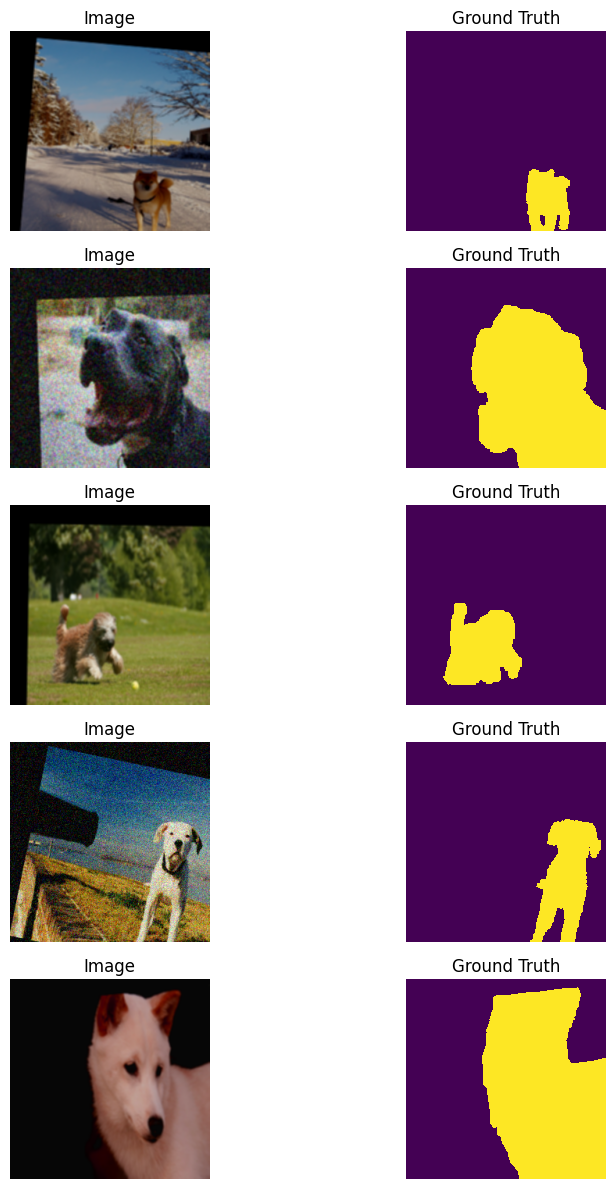

In [18]:
visualize_dataset(train_dataset, samples=5)

## загрузчик бачтей

In [19]:
BATCH = 16

train_loader = DataLoader(
                train_dataset,
                batch_size=BATCH,
                shuffle=True)

val_loader = DataLoader(
                val_dataset,
                batch_size=BATCH,
                shuffle=False)

test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH,
                shuffle=False)

# Создание модели

## Загрузка архитекутры из SMP

* Фреймворк моделей сематнической сегментации [`SMP` (Segmentation Models Pytorh)](https://smp.readthedocs.io/en/latest/) / [GitHub](https://github.com/qubvel-org/segmentation_models.pytorch)
* Архитектуры сегменатции: https://smp.readthedocs.io/en/latest/models.html
* выбор энкодров модели: https://smp.readthedocs.io/en/latest/encoders.html
* Доступные энкодеры TiMM: https://smp.readthedocs.io/en/latest/encoders_timm.html


In [20]:
model = smp.FPN(encoder_name="timm-mobilenetv3_small_075", encoder_weights="imagenet", classes=1,)

Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [21]:
summary(model, (1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
FPN                                                     [1, 1, 224, 224]          --
├─TimmUniversalEncoder: 1-1                             [1, 3, 224, 224]          --
│    └─MobileNetV3Features: 2-1                         [1, 16, 112, 112]         --
│    │    └─Conv2dSame: 3-1                             [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                            [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                              [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                             --                        573,016
├─FPNDecoder: 1-2                                       [1, 128, 56, 56]          --
│    └─Conv2d: 2-2                                      [1, 256, 7, 7]            110,848
│    └─FPNBlock: 2-3                                    [1, 256, 14, 14]          --
│    │    └─Conv2d: 3-5                          

## Создание функции потерь `SMP`

Для функции потерь будем использовать комибнацию `Dice` и бинарной кросс энтропии (`BCE`), оба значения как правило суммируются с некоторыми весами.  Это связно с тем, что значения `BCE` более чувствительны к таким вещам, как небольшие изменения формы объекта, тогда как `Dice` более чувствителен к геометрическому расположению сегментируемой области.

Таким образом в функции потерь будет учитываться место объекта и его площадь (`Dice`), а также особенности формы объекта с точки зрения его параметров, например яркости или особенностей формы (например широховатости краев) (`BCE`).

In [22]:
# Используем встроенные функции SMP
class SMPCombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5):
        super().__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.0)
        self.dice_weight = dice_weight

    def forward(self, pred, target):
        # Убедимся, что target имеет правильную размерность
        if target.dim() == 3:
            target = target.unsqueeze(1)  # Добавляем размерность канала
        target = target.float()
        
        dice = self.dice_loss(pred, target)
        bce = self.bce_loss(pred, target)
        return self.dice_weight * dice +  (1-self.dice_weight) * bce

## Метрики

In [23]:
# Метрики из SMP
def iou_score(pred, target):
    if target.dim() == 3:
        target = target.unsqueeze(1)  # Добавляем размерность канала
    # Преобразуем в бинарные предсказания
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    target = target.float()
    
    intersection = (pred_bin * target).sum((1, 2, 3))
    union = (pred_bin + target - pred_bin * target).sum((1, 2, 3))
    
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def f_score(pred, target):
    if target.dim() == 3:
        target = target.unsqueeze(1)  # Добавляем размерность канала
    # Преобразуем в бинарные предсказания
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    target = target.float()
    
    intersection = (pred_bin * target).sum((1, 2, 3))
    total_pred = pred_bin.sum((1, 2, 3))
    total_target = target.sum((1, 2, 3))
    
    f1 = (2 * intersection + 1e-6) / (total_pred + total_target + 1e-6)
    return f1.mean()

def accuracy_score(pred, target):
    if target.dim() == 3:
        target = target.unsqueeze(1)  # Добавляем размерность канала
    # Преобразуем в бинарные предсказания
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    target = target.float()
    
    correct = (pred_bin == target).float().sum((1, 2, 3))
    total = target.new_tensor(target.shape[1] * target.shape[2] * target.shape[3])
    
    acc = (correct + 1e-6) / (total + 1e-6)
    return acc.mean()

def g_dice_score(pred, target):
    """
    Generalized Dice Score (GDice) - учитывает классы с разными весами
    """
    if target.dim() == 3:
        target = target.unsqueeze(1)  # Добавляем размерность канала
    
    # Преобразуем в бинарные предсказания
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    target = target.float()
    
    # Вычисляем площади для каждого класса (в бинарной задаче - только для 1)
    pred_area = pred_bin.sum((1, 2, 3))  # [batch_size]
    target_area = target.sum((1, 2, 3))  # [batch_size]
    
    # Вычисляем веса (обратно пропорционально площади, чтобы уравновесить)
    weights = 1.0 / (target_area + 1e-6)**2  # [batch_size]
    
    # Вычисляем intersection и union с весами
    intersection = (pred_bin * target).sum((1, 2, 3))  # [batch_size]
    
    # GDice = 2 * sum(w_i * intersection_i) / sum(w_i * (area_pred_i + area_target_i))
    weighted_intersection = (weights * intersection).sum()
    weighted_union = (weights * (pred_area + target_area)).sum()
    
    g_dice = (2 * weighted_intersection + 1e-6) / (weighted_union + 1e-6)
    return g_dice


In [24]:
# Определим метрики
metrics = {
    'iou': iou_score,
    'f1': f_score,
    'acc': accuracy_score,
    'gdice': g_dice_score
}

## Обучение модели

### Инициализация обучения

In [25]:
LR = 0.001
criterion = SMPCombinedLoss(dice_weight=0.5)
criterion.to(device)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)  # базовый LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

### Обучение

In [26]:
EPOCHS = 10

# Запускаем обучение
history_df, batch_history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    metrics=metrics,
    epochs=EPOCHS,
    scheduler = scheduler,
    device=device,
    checkpoint_path="best_segmentation_model.pt",
    monitor_metric="iou",
    mode="max",
    patience=3,
    min_delta=1e-4,
    verbose=True,
    return_batch_history = True,
)



Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 01 | Time: 41.1s | LR: 1.00e-03 | Train Loss: 0.2490 | Val Loss: 0.1447 | Val iou: 0.8495 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 02 | Time: 12.5s | LR: 1.00e-03 | Train Loss: 0.1593 | Val Loss: 0.1368 | Val iou: 0.8550 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 03 | Time: 12.4s | LR: 1.00e-03 | Train Loss: 0.1376 | Val Loss: 0.1216 | Val iou: 0.8684 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 04 | Time: 12.4s | LR: 1.00e-03 | Train Loss: 0.1299 | Val Loss: 0.1187 | Val iou: 0.8723 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 05 | Time: 12.1s | LR: 1.00e-03 | Train Loss: 0.1292 | Val Loss: 0.1240 | Val iou: 0.8674 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 06 | Time: 12.5s | LR: 1.00e-03 | Train Loss: 0.1174 | Val Loss: 0.1133 | Val iou: 0.8783 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 07 | Time: 12.5s | LR: 1.00e-03 | Train Loss: 0.1114 | Val Loss: 0.1396 | Val iou: 0.8650 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 08 | Time: 12.4s | LR: 1.00e-03 | Train Loss: 0.1119 | Val Loss: 0.1126 | Val iou: 0.8809 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 09 | Time: 12.5s | LR: 1.00e-03 | Train Loss: 0.1061 | Val Loss: 0.1260 | Val iou: 0.8720 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10 | Time: 12.7s | LR: 1.00e-03 | Train Loss: 0.1075 | Val Loss: 0.1293 | Val iou: 0.8684 


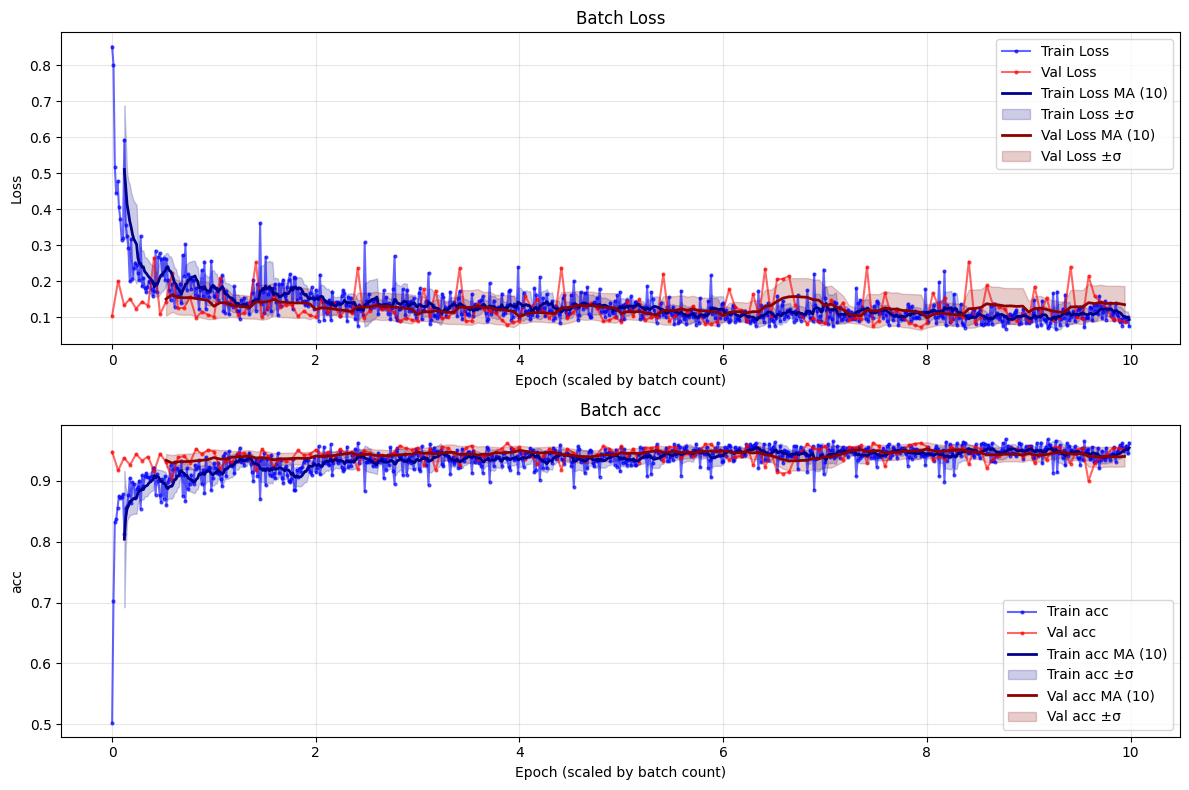

In [27]:
plot_batch_history(batch_history, metric_name='acc', window=10)

### Загрузка результата

In [28]:
info = load_checkpoint(model, optimizer, scheduler, "best_segmentation_model.pt", device)
info['epoch'], info['best_score'], info['best_epoch'],

(7, 0.880883143228643, 7)

или просто модель загружаем

In [29]:
checkpoint = torch.load('best_segmentation_model.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

### провеврка на валидации

In [30]:
test_results = evaluate(model, val_loader, metrics, device=device, return_batch_metrics=False)
print(10*'--',f'\nTest results: {test_results}')

Evaluate:   0%|          | 0/17 [00:00<?, ?it/s]

-------------------- 
Test results: {'metrics': {'iou': 0.880883143228643, 'f1': 0.932755007463343, 'acc': 0.949709555682014, 'gdice': 0.8640492558479309}}


### проверка на тесте

In [31]:
test_results = evaluate(model, test_loader, metrics, device=device, return_batch_metrics=False)
print(10*'--',f'\nTest results: {test_results}')

Evaluate:   0%|          | 0/2 [00:00<?, ?it/s]

-------------------- 
Test results: {'metrics': {'iou': 0.8356645107269287, 'f1': 0.9065060913562775, 'acc': 0.9476823806762695, 'gdice': 0.8884978890419006}}


## Проверка на примерах

### загрузим батч

In [32]:
x,y = next(iter(test_loader))
x,y = x.to(device), y.to(device)
y_pred = torch.sigmoid(model.forward(x))
y_pred.shape, y.shape, x.shape

(torch.Size([16, 1, 256, 256]),
 torch.Size([16, 256, 256]),
 torch.Size([16, 3, 256, 256]))

### проверим изображение

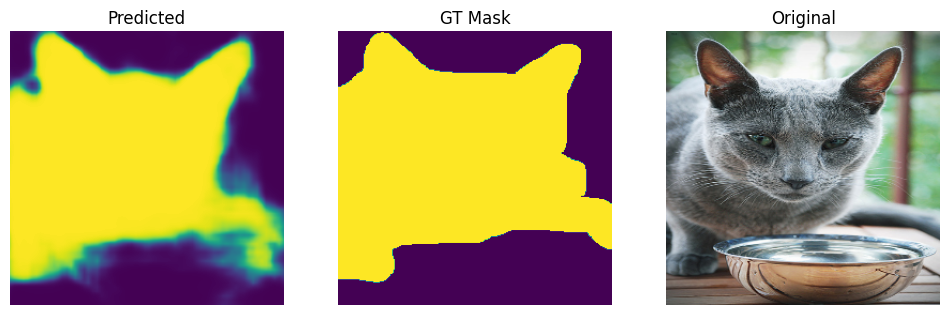

In [34]:
id = 0
fig, axs = plt.subplots(1,3, figsize = (12,4))
predict = y_pred[id].detach().cpu().numpy().transpose((1,2,0))
axs[0].imshow(predict);  axs[0].set_axis_off(); axs[0].set_title('Predicted')

gt_mask =y[id].detach().cpu().numpy()
axs[1].imshow(gt_mask); axs[1].set_axis_off(); axs[1].set_title('GT Mask')

img = x[id].detach().cpu().numpy().transpose((1,2,0))
img = np.clip(img*STD + MEAN,0,1)
axs[2].imshow(img); axs[2].set_axis_off(); axs[2].set_title('Original'); plt.show()

#### нехватает порога


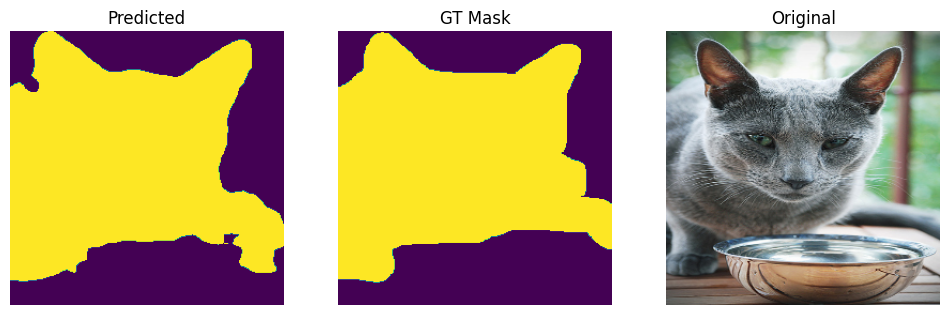

In [35]:
THRESHOLD = 0.5
fig, axs = plt.subplots(1,3, figsize = (12,4))
predict = predict>THRESHOLD
axs[0].imshow(predict);  axs[0].set_axis_off(); axs[0].set_title('Predicted')
axs[1].imshow(gt_mask); axs[1].set_axis_off(); axs[1].set_title('GT Mask')
axs[2].imshow(img); axs[2].set_axis_off(); axs[2].set_title('Original'); plt.show()

# Архитектура UNet

## Описание архитекутры

В данном уроке мы будем будем решать задачу сематической сегментации  на основе архитектуры `U-Net`. Данная архитектура состоит из двух частей: энкодера и декодера. Обе части имеют следующее назначение.
* __Энкодер__ (кодировщик, encoder) сжимает исходные данные в т.н. "набор карт латентных признаков". То есть выделить и "закодировать" признаки в заданное, достаточно большое, число карт признаков небольшого размера. Однако, особенностью энкодера является выделение и сохранение карт признаков на разных этапах сжатия.
* __Декодер__ (decoder) занимается раскодированием признаков в карыт выхондого размера. Однако, в архитектурах `U-Net`, такое раскодирование происходит с использованием информации, сохраненной энкодером на каждом из соответствующих этапов. Это достигается за счет соединения слоев, получаемых в декодере непосредственно и аналогичных по размеру слоев энкодера.

Отметим, что архитектура `U-Net` была предложенна в 2015 для решения ряда медицинских задач, офицальная статья может быть найдена по ссылке [тут](https://arxiv.org/abs/1505.04597). На данный момент семейство архитектур на базе `U-Net` является одним из наиболее популярных для решения задач семантической сегментации.

Схема данной сети показана на рисунке ниже.


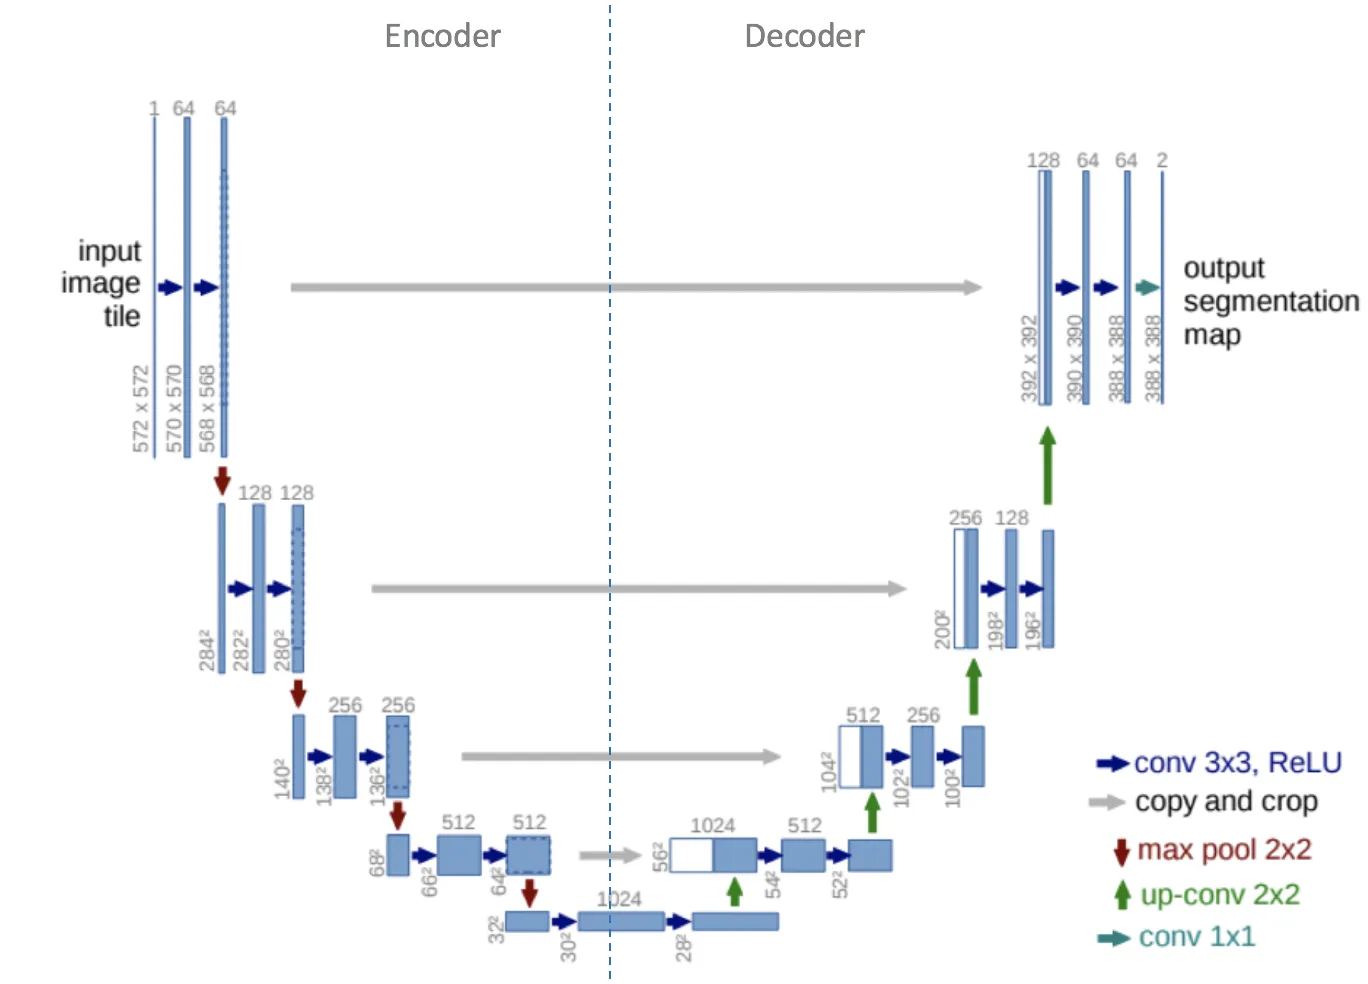

> Отметим, что на официальном сайте `PyTorch` может быть найден пример работы с `U-Net` при помощи `torch.hub` ([тут](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)). А также, порекомендуем сторонюю библиотеку для работы с моделями семантической сетментации [segmentation_models_pytorch](https://github.com/qubvel/segmentation_models.pytorch).

## основной блок

Теперь опишим стандартную архитектуру `U-Net`. В данном случае мы будем описывать архитектуру "с нуля".

Отметим, что при необходимости также можно ознакомится с [этим](https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py) примером.

В основе архитектуры будет лежать блок заданного типа `DoubleConv`. 
Блок состоит из двух сверток, сохраняющих размерность карт признаков. Число каналов сверток может управляться.

 Ниже приведена более классическая реализация архитектуры `UNet`.  Такие рализации можно найтит например [тут](https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py) или [тут](https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py) Сравните результат работы такой модели с полученной.

In [36]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

## Блоки понижения и повышения размерности

Зададим операции scaling и блок формирования выхода 

In [37]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## Архитектура U-Net

Теперь составим из блоков архитектуру.  
* Архитектура будет состоять из 5 ступеней (аналогично `ResNet`).
* Каждая стуепнь энкодера сжимает размер карт аризнака в два раза и увеличивает число карт признаков в степень 2.
* Выход каждой ступени необходимо сохранить, так как он будет использоваться в декодере.
* Каждая ступень декодера повышает разменость входящей карты признаков.
* Затем к картам признаков декодера добавляются признаки энкодера как новые каналы. То есть методом конкатенации.
* Полученный набор карт признаков проходит через сверточный блок.
* Размер архитектуры буде задаваться параметром SIZE
* Архитектура имеет 2 варианта: с расширением при помощи билинейной интерполяции и при помощи транспонированной свертки

In [38]:
SIZE = 16

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, SIZE)
        self.down1 = Down(SIZE, 2*SIZE)
        self.down2 = Down(2*SIZE, 4*SIZE)
        self.down3 = Down(4*SIZE, 8*SIZE)
        factor = 2 if bilinear else 1
        self.down4 = Down(8*SIZE, 16*SIZE // factor)
        
        self.up1 = Up(16*SIZE, 8*SIZE // factor, bilinear)
        self.up2 = Up(8*SIZE, 4*SIZE // factor, bilinear)
        self.up3 = Up(4*SIZE, 2*SIZE // factor, bilinear)
        self.up4 = Up(2*SIZE,SIZE, bilinear)
        self.outc = OutConv(SIZE, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [39]:
model = UNet(n_channels=3, n_classes=1)
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 1, 256, 256]          --
├─DoubleConv: 1-1                             [1, 16, 256, 256]         --
│    └─Sequential: 2-1                        [1, 16, 256, 256]         --
│    │    └─Conv2d: 3-1                       [1, 16, 256, 256]         432
│    │    └─BatchNorm2d: 3-2                  [1, 16, 256, 256]         32
│    │    └─ReLU: 3-3                         [1, 16, 256, 256]         --
│    │    └─Conv2d: 3-4                       [1, 16, 256, 256]         2,304
│    │    └─BatchNorm2d: 3-5                  [1, 16, 256, 256]         32
│    │    └─ReLU: 3-6                         [1, 16, 256, 256]         --
├─Down: 1-2                                   [1, 32, 128, 128]         --
│    └─Sequential: 2-2                        [1, 32, 128, 128]         --
│    │    └─MaxPool2d: 3-7                    [1, 16, 128, 128]         --
│    │    └─Doub

## Обучение модели

### Инициализация обучения

In [40]:
LR = 0.001
criterion = SMPCombinedLoss(dice_weight=0.5)
criterion.to(device)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)  # базовый LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

### Обучение

In [44]:
EPOCHS = 30

# Запускаем обучение
history_df, batch_history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    metrics=metrics,
    epochs=EPOCHS,
    scheduler = scheduler,
    device=device,
    checkpoint_path="best_segmentation_model.pt",
    monitor_metric="iou",
    mode="max",
    patience=3,
    min_delta=1e-4,
    verbose=True,
    return_batch_history = True,
    start_from_checkpoint = "best_segmentation_model.pt"
)



Loaded checkpoint 'best_segmentation_model.pt' | Starting from epoch 12 | Best score: 0.730440


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13 | Time: 15.2s | LR: 1.00e-03 | Train Loss: 0.2471 | Val Loss: 0.2513 | Val iou: 0.7378 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14 | Time: 14.8s | LR: 1.00e-03 | Train Loss: 0.2390 | Val Loss: 0.2717 | Val iou: 0.7215 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15 | Time: 15.2s | LR: 1.00e-03 | Train Loss: 0.2409 | Val Loss: 0.2703 | Val iou: 0.7248 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16 | Time: 14.7s | LR: 1.00e-03 | Train Loss: 0.2357 | Val Loss: 0.2894 | Val iou: 0.7197 
Early stopping at epoch 16. Best: 0.737814 at epoch 13


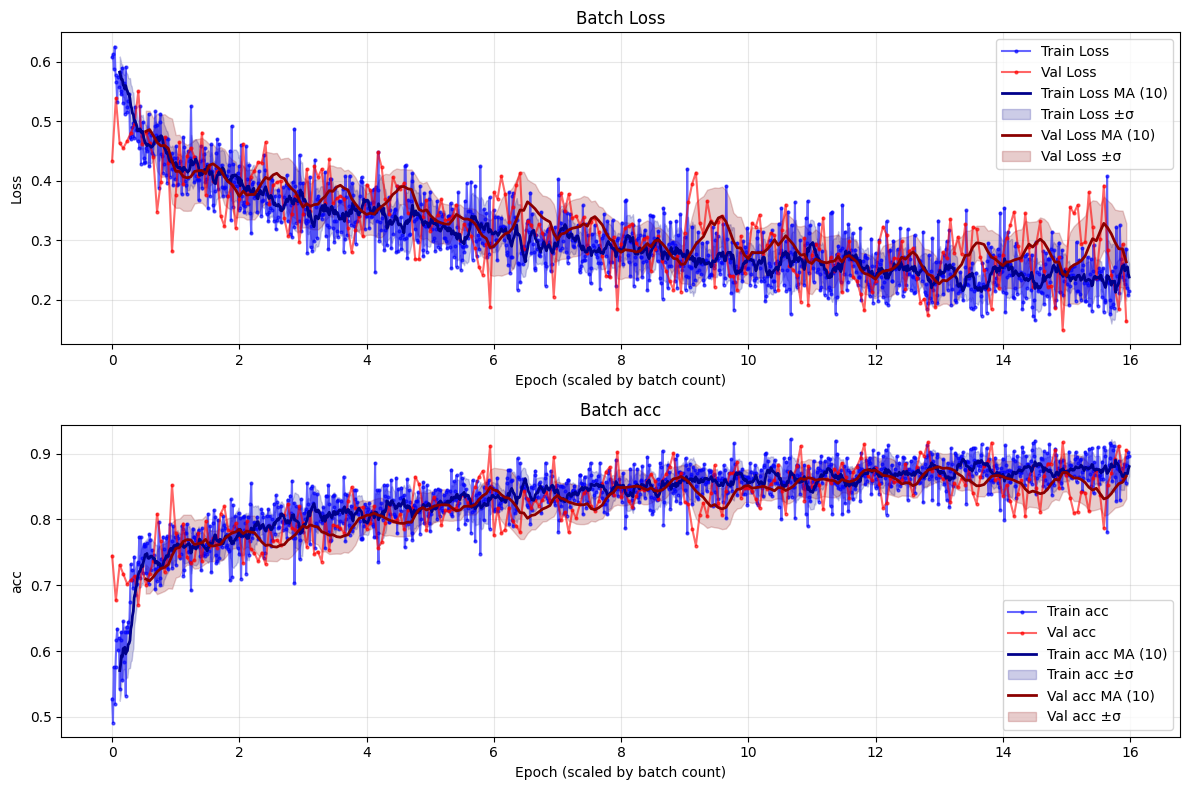

In [45]:
plot_batch_history(batch_history, metric_name='acc', window=10)

### Загрузка результата

In [158]:
info = load_checkpoint(model, optimizer, scheduler, "best_segmentation_model.pt", device)
info['epoch'], info['best_score'], info['best_epoch'],

(1, 0.8984107164775624, 1)

или просто модель загружаем

In [159]:
checkpoint = torch.load('best_segmentation_model.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

### провеврка на валидации

In [160]:
test_results = evaluate(model, val_loader, metrics, device=device, return_batch_metrics=False)
print(10*'--',f'\nTest results: {test_results}')

Evaluate:   0%|          | 0/17 [00:00<?, ?it/s]

-------------------- 
Test results: {'metrics': {'iou': 0.8984107164775624, 'f1': 0.942885532098658, 'acc': 0.9574683133293601, 'gdice': 0.8774416411624235}}


### проверка на тесте

In [161]:
test_results = evaluate(model, test_loader, metrics, device=device, return_batch_metrics=False)
print(10*'--',f'\nTest results: {test_results}')

Evaluate:   0%|          | 0/2 [00:00<?, ?it/s]

-------------------- 
Test results: {'metrics': {'iou': 0.8847401440143585, 'f1': 0.9364128112792969, 'acc': 0.9622249603271484, 'gdice': 0.9232809841632843}}


## Проверка на примерах

### загрузим батч

In [162]:
x,y = next(iter(test_loader))
x,y = x.to(device), y.to(device)
y_pred = torch.sigmoid(model.forward(x))
y_pred.shape, y.shape, x.shape

(torch.Size([16, 1, 256, 256]),
 torch.Size([16, 256, 256]),
 torch.Size([16, 3, 256, 256]))

### проверим изображение

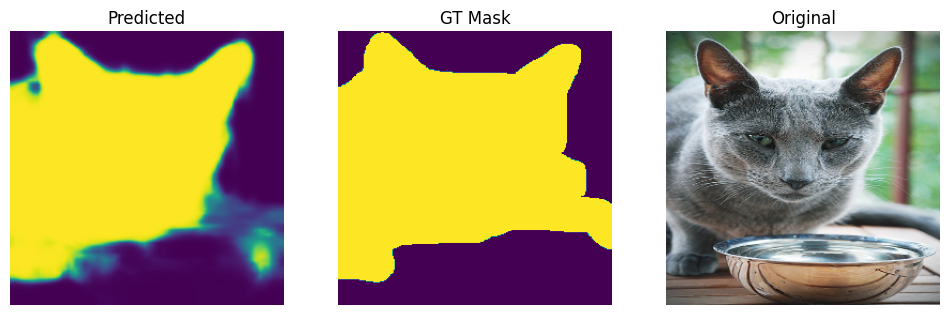

In [163]:
id = 0
fig, axs = plt.subplots(1,3, figsize = (12,4))
predict = y_pred[id].detach().cpu().numpy().transpose((1,2,0))
axs[0].imshow(predict);  axs[0].set_axis_off(); axs[0].set_title('Predicted')

gt_mask =y[id].detach().cpu().numpy()
axs[1].imshow(gt_mask); axs[1].set_axis_off(); axs[1].set_title('GT Mask')

img = x[id].detach().cpu().numpy().transpose((1,2,0))
img = np.clip(img*STD + MEAN,0,1)
axs[2].imshow(img); axs[2].set_axis_off(); axs[2].set_title('Original'); plt.show()

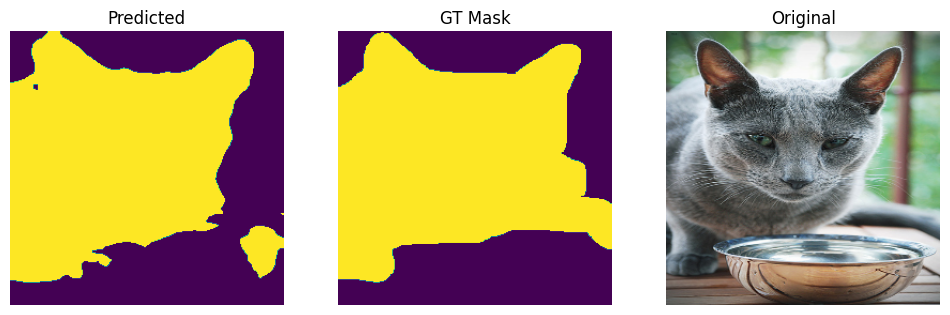

In [164]:
THRESHOLD = 0.3
fig, axs = plt.subplots(1,3, figsize = (12,4))
predict = predict>THRESHOLD
axs[0].imshow(predict);  axs[0].set_axis_off(); axs[0].set_title('Predicted')
axs[1].imshow(gt_mask); axs[1].set_axis_off(); axs[1].set_title('GT Mask')
axs[2].imshow(img); axs[2].set_axis_off(); axs[2].set_title('Original'); plt.show()

# Задания

## Упражнения с U-Net

__1.__ Особенностью  `UNet` является наличие связей между картами признаков энкодера и декодера на разных этапах. Это позволяет улавливать мелко-размерные объекты и особенности сегментируемых участков. Однако, с точки зрения вычислительных рессурсов это дополнительные вычислительне затраты. Поэтому ряд архитектур, таких как SegNet не используют карты признаков, а используют unpooling.
__Предлагается__ преобразовать архитектуру `UNet` в `SegNet`, сравните результаты.

__2.__ Ранее рассматривались различные приемы улучшения архитектур нейронных сетей, например использование глубокой разделенной свертки или блока ConvNext. __Предлагается__ проверить качество работы архитектуры при указанных изменениях.

__3.__ Пакет `SMP` cодержит функцию потерь `FocalLoss`, позволяющую решать задачи с дисбалансом классов. Такой дисбаланс возникает в силу неравномерности различных локальных областей сегментации и фона на изображениях. __Предлагаем__ реализовать обучение с использованием `FocalLoss`.

__4.__ В современном подходе дифузоинные нейронные сети архитектура типа UNet используется в качестве архитектуры для решения задачи `denoising`. Это задача без учителя типа автоэнкодер. В задаче на вход подается зашумленное изображение, выход должен быть освобожден от шумов. Как мнимум это можно сделать сравнить вход до зашумления с выходом при помощи регрессионной функции потерь. __Предлагаем__ реализовать такую архитекутру.

## Упражнения с Timm custom U-Net

__5.__ Ниже приведена реализация архитектуры `UNet` при помощи `Timm` Энкодера.  Сравните результат работы такой модели с полученной.

In [76]:
import timm

class TimmUNet(nn.Module):
    """U-Net с использованием backbone из timm"""
    def __init__(self, 
                 backbone_name='mobilenetv3_small_100',  # легкий backbone
                 in_channels=3, 
                 out_channels=1,
                 pretrained=True):
        super().__init__()
        
        # Загружаем предобученную модель
        self.backbone = timm.create_model(
            backbone_name, 
            features_only=True, 
            pretrained=pretrained,
            out_indices=(0, 1, 2, 3)  # выбираем разные уровни
        )
        
        # Получаем количество каналов для каждого уровня
        self.feature_channels = self.backbone.feature_info.channels()
        
        # Уменьшаем количество каналов для легкости
        self.reduce_convs = nn.ModuleList()
        for ch in self.feature_channels:
            self.reduce_convs.append(
                nn.Conv2d(ch, 32, 1)  # уменьшаем до 32 каналов
            )
        
        # Decoder
        self.decoder_blocks = nn.ModuleList()
        
        # Для каждого уровня decoder создаем upsampling + conv
        for i in range(len(self.feature_channels) - 1):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)  # upsampling
            )
            # После конкатенации: 32 (upsampled) + 32 (skip) = 64
            self.decoder_blocks.append(
                nn.Sequential(
                    nn.Conv2d(64, 32, 3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(32, 32, 3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(inplace=True)
                )
            )
        
        # Дополнительный upsampling до исходного размера
        # Если после decoder все еще меньше чем вход, добавляем еще upsampling
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Final output layer
        self.output = nn.Conv2d(32, out_channels, 1)
        
    def forward(self, x):
        # Получаем признаки из backbone
        features = self.backbone(x)
        
        # Уменьшаем количество каналов
        reduced_features = []
        for feat, conv in zip(features, self.reduce_convs):
            reduced_features.append(conv(feat))
        
        # Начинаем с самого глубокого уровня
        x = reduced_features[-1]
        
        # Decoder с skip connections
        for i in range(0, len(self.decoder_blocks), 2):
            # Upsampling
            x = self.decoder_blocks[i](x)
            
            # Добавляем skip connection
            skip_idx = len(reduced_features) - 2 - (i // 2)
            if skip_idx >= 0:
                skip = reduced_features[skip_idx]
                
                # Убедимся, что размеры совпадают
                if x.shape[2:] != skip.shape[2:]:
                    x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
                
                x = torch.cat([x, skip], dim=1)
            
            # Convolution block
            x = self.decoder_blocks[i+1](x)
        
        # Дополнительный upsampling до размера входа, если нужно
        if x.shape[2:] != features[0].shape[2:]:
            x = self.final_upsample(x)
        
        # Убедимся, что размер совпадает с входом
        if x.shape[2:] != torch.Size([256, 256]):
            x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=True)
        
        return self.output(x)



In [77]:
# Пример использования
model = TimmUNet(
    backbone_name='mobilenetv3_small_050',  # очень легкий backbone
    in_channels=3, 
    out_channels=1,
    pretrained=True
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Проверка размеров
x = torch.randn(1, 3, 256, 256)
with torch.no_grad():
    y = model(x)
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")

Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Model parameters: 370,401
Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


In [78]:
LR = 0.001
criterion = SMPCombinedLoss(dice_weight=0.5)
criterion.to(device)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)  # базовый LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [79]:
EPOCHS = 30

# Запускаем обучение
history_df, batch_history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    metrics=metrics,
    epochs=EPOCHS,
    scheduler = scheduler,
    device=device,
    checkpoint_path="best_segmentation_model.pt",
    monitor_metric="iou",
    mode="max",
    patience=3,
    min_delta=1e-4,
    verbose=True,
    return_batch_history = True,
    # start_from_checkpoint= "best_segmentation_model.pt",
)


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 01 | Time: 17.3s | LR: 1.00e-03 | Train Loss: 0.3169 | Val Loss: 0.2663 | Val iou: 0.7496 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 02 | Time: 13.0s | LR: 1.00e-03 | Train Loss: 0.2180 | Val Loss: 0.1913 | Val iou: 0.7986 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 03 | Time: 12.4s | LR: 1.00e-03 | Train Loss: 0.1859 | Val Loss: 0.2296 | Val iou: 0.7681 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 04 | Time: 12.9s | LR: 1.00e-03 | Train Loss: 0.1782 | Val Loss: 0.1710 | Val iou: 0.8233 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 05 | Time: 12.9s | LR: 1.00e-03 | Train Loss: 0.1663 | Val Loss: 0.1711 | Val iou: 0.8157 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 06 | Time: 13.1s | LR: 1.00e-03 | Train Loss: 0.1632 | Val Loss: 0.1631 | Val iou: 0.8261 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 07 | Time: 13.2s | LR: 1.00e-03 | Train Loss: 0.1633 | Val Loss: 0.1655 | Val iou: 0.8224 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 08 | Time: 13.0s | LR: 1.00e-03 | Train Loss: 0.1529 | Val Loss: 0.1728 | Val iou: 0.8187 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 09 | Time: 12.8s | LR: 1.00e-03 | Train Loss: 0.1559 | Val Loss: 0.1563 | Val iou: 0.8350 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10 | Time: 12.3s | LR: 1.00e-03 | Train Loss: 0.1458 | Val Loss: 0.1524 | Val iou: 0.8354 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11 | Time: 12.5s | LR: 1.00e-03 | Train Loss: 0.1458 | Val Loss: 0.1493 | Val iou: 0.8421 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12 | Time: 12.9s | LR: 1.00e-03 | Train Loss: 0.1476 | Val Loss: 0.1459 | Val iou: 0.8411 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13 | Time: 12.9s | LR: 1.00e-03 | Train Loss: 0.1472 | Val Loss: 0.1698 | Val iou: 0.8171 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14 | Time: 12.6s | LR: 1.00e-03 | Train Loss: 0.1396 | Val Loss: 0.1568 | Val iou: 0.8332 
Early stopping at epoch 14. Best: 0.842056 at epoch 11


## SegFromer from HuggingFace

__6.__ Ниже также показан пример загрузки модели `Segformer` из пакета `HuggingFace`. Отметим, что модель segformer  есть также и в SMP. Но в текущей версии модель с HF почему-то работает лучше. 

Также важно отметить, что для модели выход имеет размер не равный входу. Поэтому для модели сделан класс `HFSegFormerWrapper`, который задает выходной слой модели с нужным размером.

<blockquote>
    

Для вызова из SMP можно использовать следующий код:
```python
    model = smp.Segformer(
        encoder_name='mit_b0',  
        encoder_weights="imagenet",  
        in_channels=3,  
        classes=num_classes, 
    )
```

</blockquote>

In [152]:
from transformers import SegformerForSemanticSegmentation, SegformerConfig

class HFSegFormerWrapper(nn.Module):
    """
    Обёртка для SegFormer из transformers, чтобы он возвращал маску
    того же размера, что и вход (или размер, который вы ожидаете).
    """
    def __init__(self, hf_segformer_model, target_size=None):
        super().__init__()
        self.segformer = hf_segformer_model
        self.target_size = target_size

    def forward(self, x):
        # x: [B, C, H_in, W_in]
        # outputs может быть тензором (логитами) или ModelOutput, в зависимости от реализации
        outputs = self.segformer(x) # pixel_values = x

        # Проверяем тип возвращаемого значения
        if isinstance(outputs, dict):
            # Если это словарь, ищем 'logits'
            logits = outputs.get('logits')
        elif hasattr(outputs, 'logits'):
            # Если это ModelOutput или объект с атрибутом logits
            logits = outputs.logits
        elif torch.is_tensor(outputs):
            # Если это просто тензор, предполагаем, что это logits
            logits = outputs
        else:
            # Если тип неожиданный, вызываем ошибку
            raise TypeError(f"Unexpected output type from segformer: {type(outputs)}")

        # Интерполируем до размера входа или до target_size
        if self.target_size:
            logits = F.interpolate(logits, size=self.target_size, mode="bilinear", align_corners=False)
        else:
            # Интерполируем до размера входного тензора x
            logits = F.interpolate(logits, size=x.shape[2:], mode="bilinear", align_corners=False)

        return logits # [B, num_classes, H_in, W_in] или [B, num_classes, target_H, target_W]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",  num_labels=1,)
model = HFSegFormerWrapper(model, target_size=(256, 256)) # или None, чтобы использовать размер входа
model.to(device)

In [153]:


# Проверка
# Важно: SMP SegFormer может требовать минимальный размер входа >= 256x256 (в зависимости от версии PyTorch)
x = torch.randn(1, 3, 256, 256).to(device) # или 512x512
with torch.no_grad():
    y = model(x)
    print(f"Input: {x.shape}, Output: {y[0].shape}") # [1, num_classes, H, W] - обычно такой же размер как вход

Input: torch.Size([1, 3, 256, 256]), Output: torch.Size([1, 256, 256])


In [154]:
for batch in train_loader:
    image, mask = batch
    model.eval()
    with torch.no_grad():
        pred = wrapped_model(image.to(device))
    print("Pred shape:", pred.shape)  # Должно быть [B, 1, H, W]
    print("Mask shape:", mask.shape)  # Должно быть [B, 1, H, W] или [B, H, W]
    break

Pred shape: torch.Size([16, 1, 256, 256])
Mask shape: torch.Size([16, 256, 256])


In [155]:
summary(model, (1,3,256,256))

Layer (type:depth-idx)                                                           Output Shape              Param #
HFSegFormerWrapper                                                               [1, 1, 256, 256]          --
├─SegformerForSemanticSegmentation: 1-1                                          [1, 1, 64, 64]            --
│    └─SegformerModel: 2-1                                                       [1, 32, 64, 64]           --
│    │    └─SegformerEncoder: 3-1                                                [1, 32, 64, 64]           3,319,392
│    └─SegformerDecodeHead: 2-2                                                  [1, 1, 64, 64]            --
│    │    └─ModuleList: 3-2                                                      --                        132,096
│    │    └─Conv2d: 3-3                                                          [1, 256, 64, 64]          262,144
│    │    └─BatchNorm2d: 3-4                                                     [1, 256, 64, 64] 

In [156]:
LR = 3e-4
criterion = SMPCombinedLoss(dice_weight=0.5)
criterion.to(device)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)  # базовый LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [157]:
EPOCHS = 30

# Запускаем обучение
history_df, batch_history = fit(
    model=wrapped_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    metrics=metrics,
    epochs=EPOCHS,
    scheduler = scheduler,
    device=device,
    checkpoint_path="best_segmentation_model.pt",
    monitor_metric="iou",
    mode="max",
    patience=10,
    min_delta=1e-5,
    verbose=True,
    return_batch_history = True,
    # start_from_checkpoint= "best_segmentation_model.pt",
)


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 01 | Time: 11.3s | LR: 3.00e-04 | Train Loss: 0.0664 | Val Loss: 0.0964 | Val iou: 0.8983 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 02 | Time: 10.9s | LR: 3.00e-04 | Train Loss: 0.0662 | Val Loss: 0.0964 | Val iou: 0.8984 ★


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 03 | Time: 11.0s | LR: 3.00e-04 | Train Loss: 0.0664 | Val Loss: 0.0974 | Val iou: 0.8982 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 04 | Time: 11.0s | LR: 3.00e-04 | Train Loss: 0.0663 | Val Loss: 0.0959 | Val iou: 0.8984 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 05 | Time: 11.2s | LR: 1.50e-04 | Train Loss: 0.0659 | Val Loss: 0.0959 | Val iou: 0.8984 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 06 | Time: 11.3s | LR: 1.50e-04 | Train Loss: 0.0667 | Val Loss: 0.0967 | Val iou: 0.8983 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 07 | Time: 11.2s | LR: 1.50e-04 | Train Loss: 0.0679 | Val Loss: 0.0962 | Val iou: 0.8984 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 08 | Time: 11.2s | LR: 1.50e-04 | Train Loss: 0.0660 | Val Loss: 0.0967 | Val iou: 0.8983 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 09 | Time: 11.2s | LR: 7.50e-05 | Train Loss: 0.0650 | Val Loss: 0.0959 | Val iou: 0.8984 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10 | Time: 11.2s | LR: 7.50e-05 | Train Loss: 0.0668 | Val Loss: 0.0962 | Val iou: 0.8984 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11 | Time: 11.2s | LR: 7.50e-05 | Train Loss: 0.0670 | Val Loss: 0.0974 | Val iou: 0.8982 


Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12 | Time: 11.1s | LR: 7.50e-05 | Train Loss: 0.0673 | Val Loss: 0.0960 | Val iou: 0.8983 
Early stopping at epoch 12. Best: 0.898411 at epoch 2
